In [35]:
import pandas as pd
import numpy as np
import bilby
import pickle

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import rcParams
import corner

In [36]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import icarogw

In [37]:
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Palatino Linotype', 'Palatino', 'TeX Gyre Pagella', 'Times New Roman']
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Palatino'
rcParams['mathtext.it'] = 'Palatino:italic'
rcParams['mathtext.bf'] = 'Palatino:bold'

In [38]:
matplotlib.rc('xtick', labelsize = 21) 
matplotlib.rc('ytick', labelsize = 21)

In [39]:
my_color = '#2f4f4f'
my_color2 = '#f6b26b'

In [40]:
default_kwargs = dict(
            bins=50, smooth=0.9,
            smooth1d=0.8,
            show_titles=False,
            title_kwargs=dict(fontsize=19),
            title_fmt='.2f',
            title_quantiles=[0.16,0.5,0.84],
            label_kwargs = dict(color = 'black', fontsize = 23),
            truth_color='black', 
            levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
            plot_density=False, plot_datapoints=False, fill_contours=True,
            max_n_ticks=3, labelpad=0.05
            )

In [41]:
path_to_plots = 'plots/'

In [42]:
injected_values_vanilla = {'H0':67.8, 
                   'Om0':0.3, 
                   'alpha':3.4, 
                   'beta':0.8, 
                   'mmin':5, 
                   'mmax':100, 
                   'delta_m':4.8, 
                   'mu_g':35, 
                   'sigma_g':3.9, 
                   'lambda_peak':0.04, 
                   'gamma':2.7, 
                   'kappa':2.9, 
                   'zp':1.9,
                   'R0':20}

injected_values_redshift = {'H0':173.28, 
                   'Om0':0.3, 
                   'alpha':5.325, 
                   'beta':3.05, 
                   'mmin':7.8, 
                   'mmax':87.58, 
                   'delta_m':3.19, 
                   'mu_g':40.9, 
                   'sigma_g':7.63, 
                   'lambda_peak':0.04, 
                   'gamma':0.03, 
                   'kappa':2.92, 
                   'zp':3.86,
                   'R0':16.1}

In [43]:
columns_lbs = ['H0', 'Om0', 'alpha', 'beta', 'mmin', 'mmax', 'delta_m', 'mu_g', 'sigma_g', 'lambda_peak',
               'gamma', 'kappa', 'zp', 'R0']

## Redshift-dependent case

In [44]:
# load dictionary of events
case2_dictionary_path = '/home/ulyana.dupletsa/MDC-Paper1/data/case2_events_dictionary.pkl'
with open(case2_dictionary_path, 'rb') as f:
    case2_dict = pickle.load(f)

In [45]:
case2_test_data = bilby.core.result.read_in_result(case2_dict['case2_inj_number']['case2_1e6inj_80ev'])
case2_test_data_posteriors = case2_test_data.posterior[columns_lbs]

### Rate plots

In [46]:
def z_dependent_rate(zz, R0, gamma, zp, kappa):
    return R0*(1+zz)**gamma*(1+(1+zp)**(-(gamma+kappa)))/(1+((1+zz)/(1+zp))**(gamma+kappa))

In [47]:
n_samples = 50

In [48]:
zz = np.linspace(0.0001, 2, n_samples)

In [49]:
R0 = injected_values_redshift['R0']
gamma = injected_values_redshift['gamma']
kappa = injected_values_redshift['kappa']
zp = injected_values_redshift['zp']

In [50]:
rate_params = ['R0', 'gamma', 'zp', 'kappa']
rate_params_lbs = ['$\gamma$', 
              '$\kappa$', 
              '$z_{\\rm p}$', 
              '$R_0$']

In [51]:
rate_posteriors = case2_test_data_posteriors[rate_params]

## Estimate the highest density region (at 68%)

In [52]:
from sklearn.neighbors import KernelDensity

In [53]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(rate_posteriors)

### Check the kde interpolation went well

In [54]:
np.random.seed(42)
kde_df = kde.sample(n_samples=len(rate_posteriors))

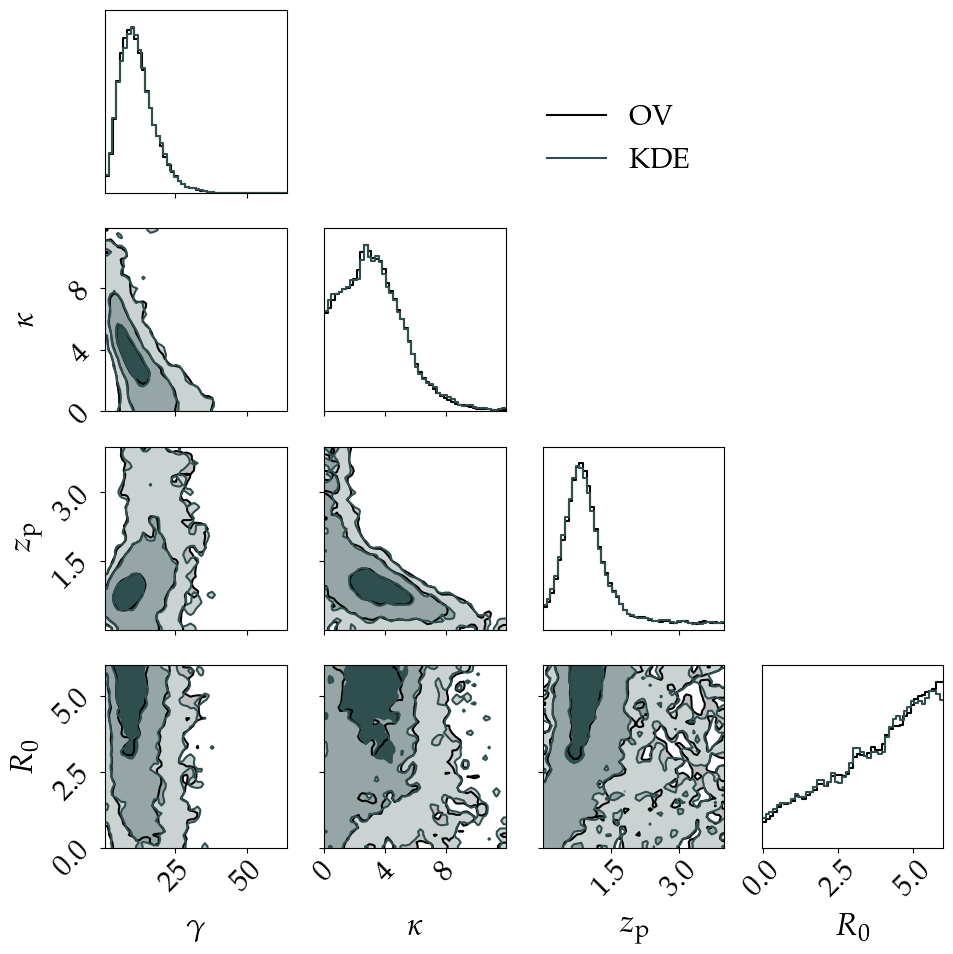

In [55]:
# compare corner plots as well
figure = corner.corner(rate_posteriors[rate_params], color = 'black', **default_kwargs)
corner.corner(kde_df, labels=rate_params_lbs, color = my_color, fig = figure, **default_kwargs)

for ax in figure.get_axes():
    ax.tick_params(axis = 'both', labelsize = 21)
    
figure.legend(['OV', 'KDE'], loc = 'center', ncol = 1, 
              bbox_to_anchor = (0.65, 0.85), fontsize = 21, frameon=False)
plt.tight_layout()
plt.show()

In [56]:
log_density = kde.score_samples(rate_posteriors)
density = np.exp(log_density)

In [57]:
rate_posteriors['density'] = density

/tmp/ipykernel_1722751/833251895.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rate_posteriors['density'] = density


In [58]:
df_sorted = rate_posteriors.sort_values('density', ascending=False)

In [59]:
df_sorted['cumulative_density'] = df_sorted['density'].cumsum()
total_density = df_sorted['density'].sum()
cutoff_density = 0.68 * total_density

In [60]:
df_hdi = df_sorted[df_sorted['cumulative_density'] <= cutoff_density]

In [61]:
from tqdm import tqdm

100%|██████████| 4532/4532 [03:08<00:00, 24.01it/s]


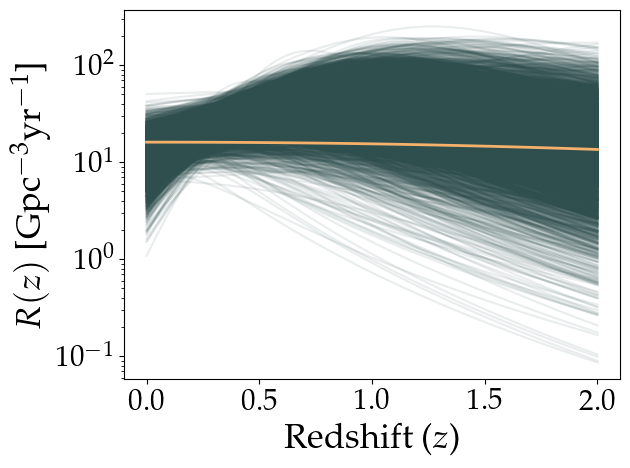

In [62]:
n_posterior_samples = len(df_hdi)

fig, ax = plt.subplots()

for i in tqdm(range(n_posterior_samples)):
    R0_sample = df_hdi['R0'].iloc[i]
    gamma_sample = df_hdi['gamma'].iloc[i]
    zp_sample = df_hdi['zp'].iloc[i]
    kappa_sample = df_hdi['kappa'].iloc[i]
    sns.lineplot(x = zz, y = z_dependent_rate(zz, R0_sample, gamma_sample, zp_sample, kappa_sample),
             color=my_color, alpha=0.1)
    
sns.lineplot(x = zz, y = z_dependent_rate(zz, R0, gamma, zp, kappa), color=my_color2,
         linewidth=2)
plt.xlabel('Redshift ($z$)', fontsize = 25)
plt.ylabel('$R(z)$ [Gpc$^{-3}$yr$^{-1}$]', fontsize = 25) 
plt.yscale('log')
plt.savefig(path_to_plots + '/' + 'redshift_rate_samples_hdi.pdf', bbox_inches='tight')
plt.show()

### Mass Plots

In [63]:
mm = np.linspace(10, 85, n_samples)

In [64]:
def alpha_z_inj(z):
    return 5.325+2.99*z
def beta_z_inj(z):
    return 3.05-1.063*z
def mmin_z_inj(z):
    return 7.8+0.324*z
def mmax_z_inj(z):
    return 87.58+17.16*z
def mu_g_z_inj(z):
    return 40.9+2.84*z
def sigma_g_z_inj(z):
    return 7.63+2.70*z
def lambda_peak_z_inj(z):
    return 0.04+0.43*z
def delta_m_z():
    return 3.19

In [65]:
import scipy.stats
import scipy

In [66]:
zz_samples= [0., 0.32, 0.85, 1.32]

In [67]:
shade0 = '#abb8b8'
shade1 = '#829595'
shade2 = '#587272'
shade3 = '#1c2f2f'

In [68]:
my_colors = [shade1, shade2, shade3]

In [69]:
red_mass_params = ['alpha', 'beta', 'mmin', 'mmax', 'delta_m', 'mu_g', 'sigma_g', 'lambda_peak']
red_mass_params_lbs = ['$\\alpha$', 
              '$\\beta$', 
              '$m_{\\rm min}$', 
              '$m_{\\rm max}$', 
              '$\\delta m$', 
              '$\\mu_{\\rm g}$', 
              '$\\sigma_{\\rm g}$', 
              '$\\lambda_{\\rm peak}$'
              ]

In [70]:
path_to_zbin1 = case2_dict['case2_zbin']['case2_1e5inj_zbin1']
zbin1_pe = bilby.core.result.read_in_result(path_to_zbin1).posterior
zbin1_pe_sel = zbin1_pe[red_mass_params]

path_to_zbin2 = case2_dict['case2_zbin']['case2_1e5inj_zbin2']
zbin2_pe = bilby.core.result.read_in_result(path_to_zbin2).posterior
zbin2_pe_sel = zbin2_pe[red_mass_params]

path_to_zbin3 = case2_dict['case2_zbin']['case2_1e5inj_zbin3']
zbin3_pe = bilby.core.result.read_in_result(path_to_zbin3).posterior
zbin3_pe_sel = zbin3_pe[red_mass_params]

## kde estimates

In [71]:
kde_bin1 = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(zbin1_pe_sel)

In [72]:
np.random.seed(42)
kde_df_bin1 = kde_bin1.sample(n_samples=len(zbin1_pe_sel))

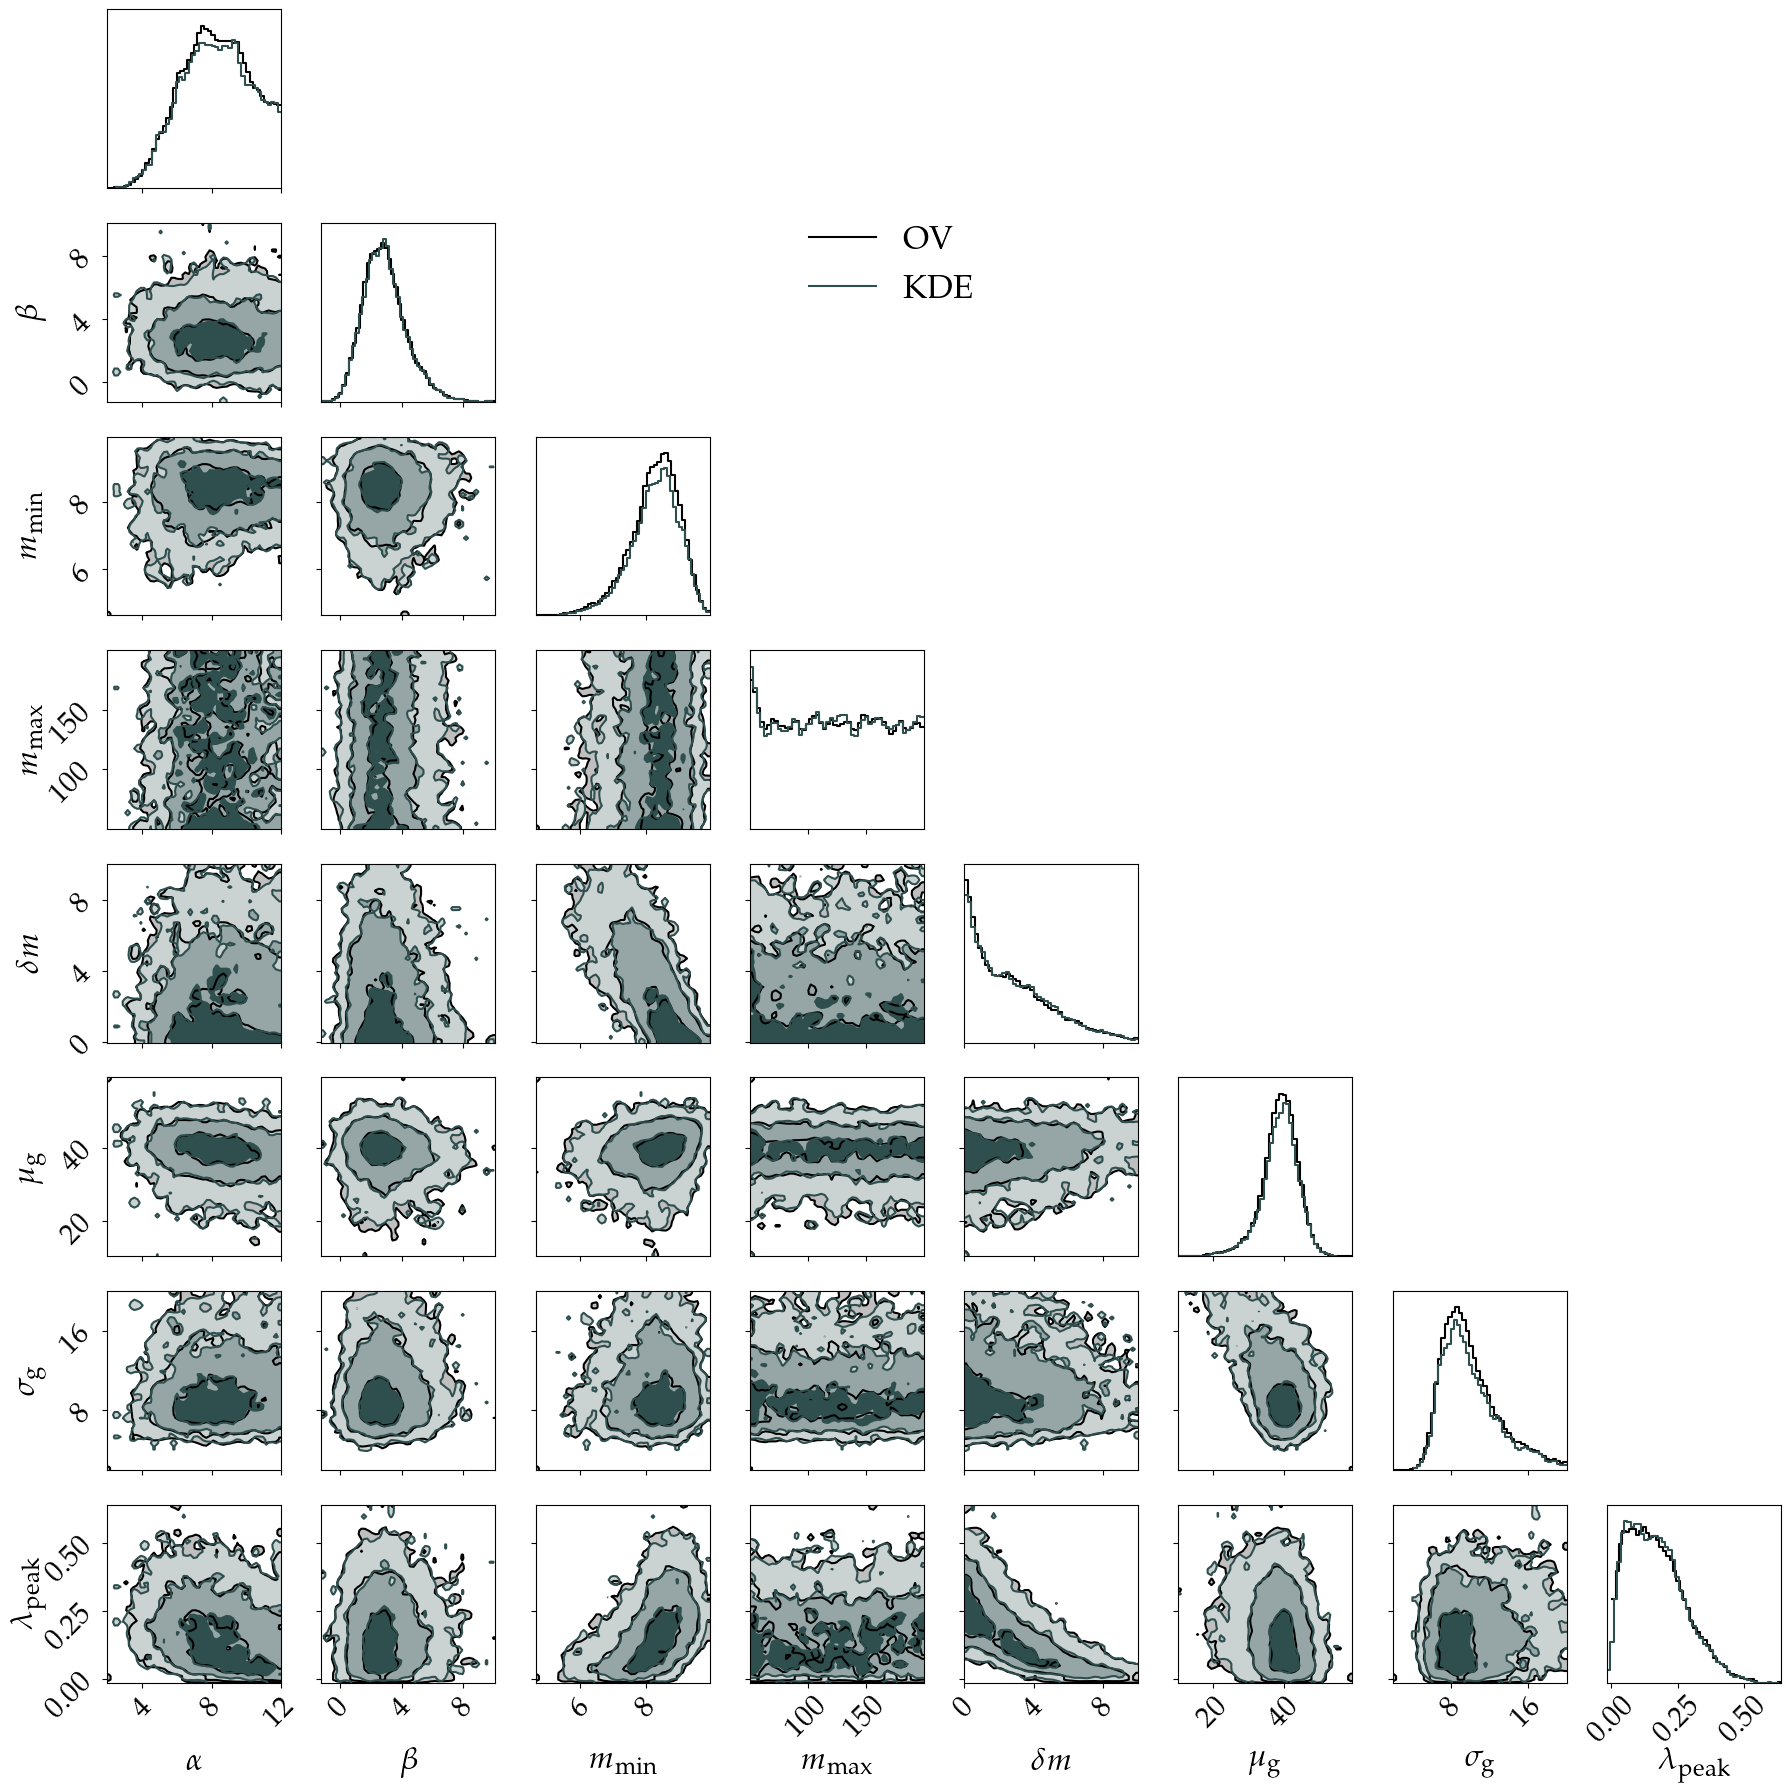

In [73]:
# compare corner plots as well
figure = corner.corner(zbin1_pe_sel[red_mass_params], color = 'black', **default_kwargs)
corner.corner(kde_df_bin1, labels=red_mass_params_lbs, color = my_color, fig = figure,  **default_kwargs)

for ax in figure.get_axes():
    ax.tick_params(axis = 'both', labelsize = 21)
    
figure.legend(['OV', 'KDE'], loc = 'center', ncol = 1, 
              bbox_to_anchor = (0.5, 0.85), fontsize = 24, frameon=False)
plt.tight_layout()
plt.show()

In [74]:
log_density = kde_bin1.score_samples(zbin1_pe_sel)
density = np.exp(log_density)
zbin1_pe_sel['density'] = density
df_bin1_sorted = zbin1_pe_sel.sort_values('density', ascending=False)
df_bin1_sorted['cumulative_density'] = df_bin1_sorted['density'].cumsum()
total_density = df_bin1_sorted['density'].sum()
cutoff_density = 0.68 * total_density
df_hdi_bin1 = df_bin1_sorted[df_bin1_sorted['cumulative_density'] <= cutoff_density]

/tmp/ipykernel_1722751/3538054733.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zbin1_pe_sel['density'] = density


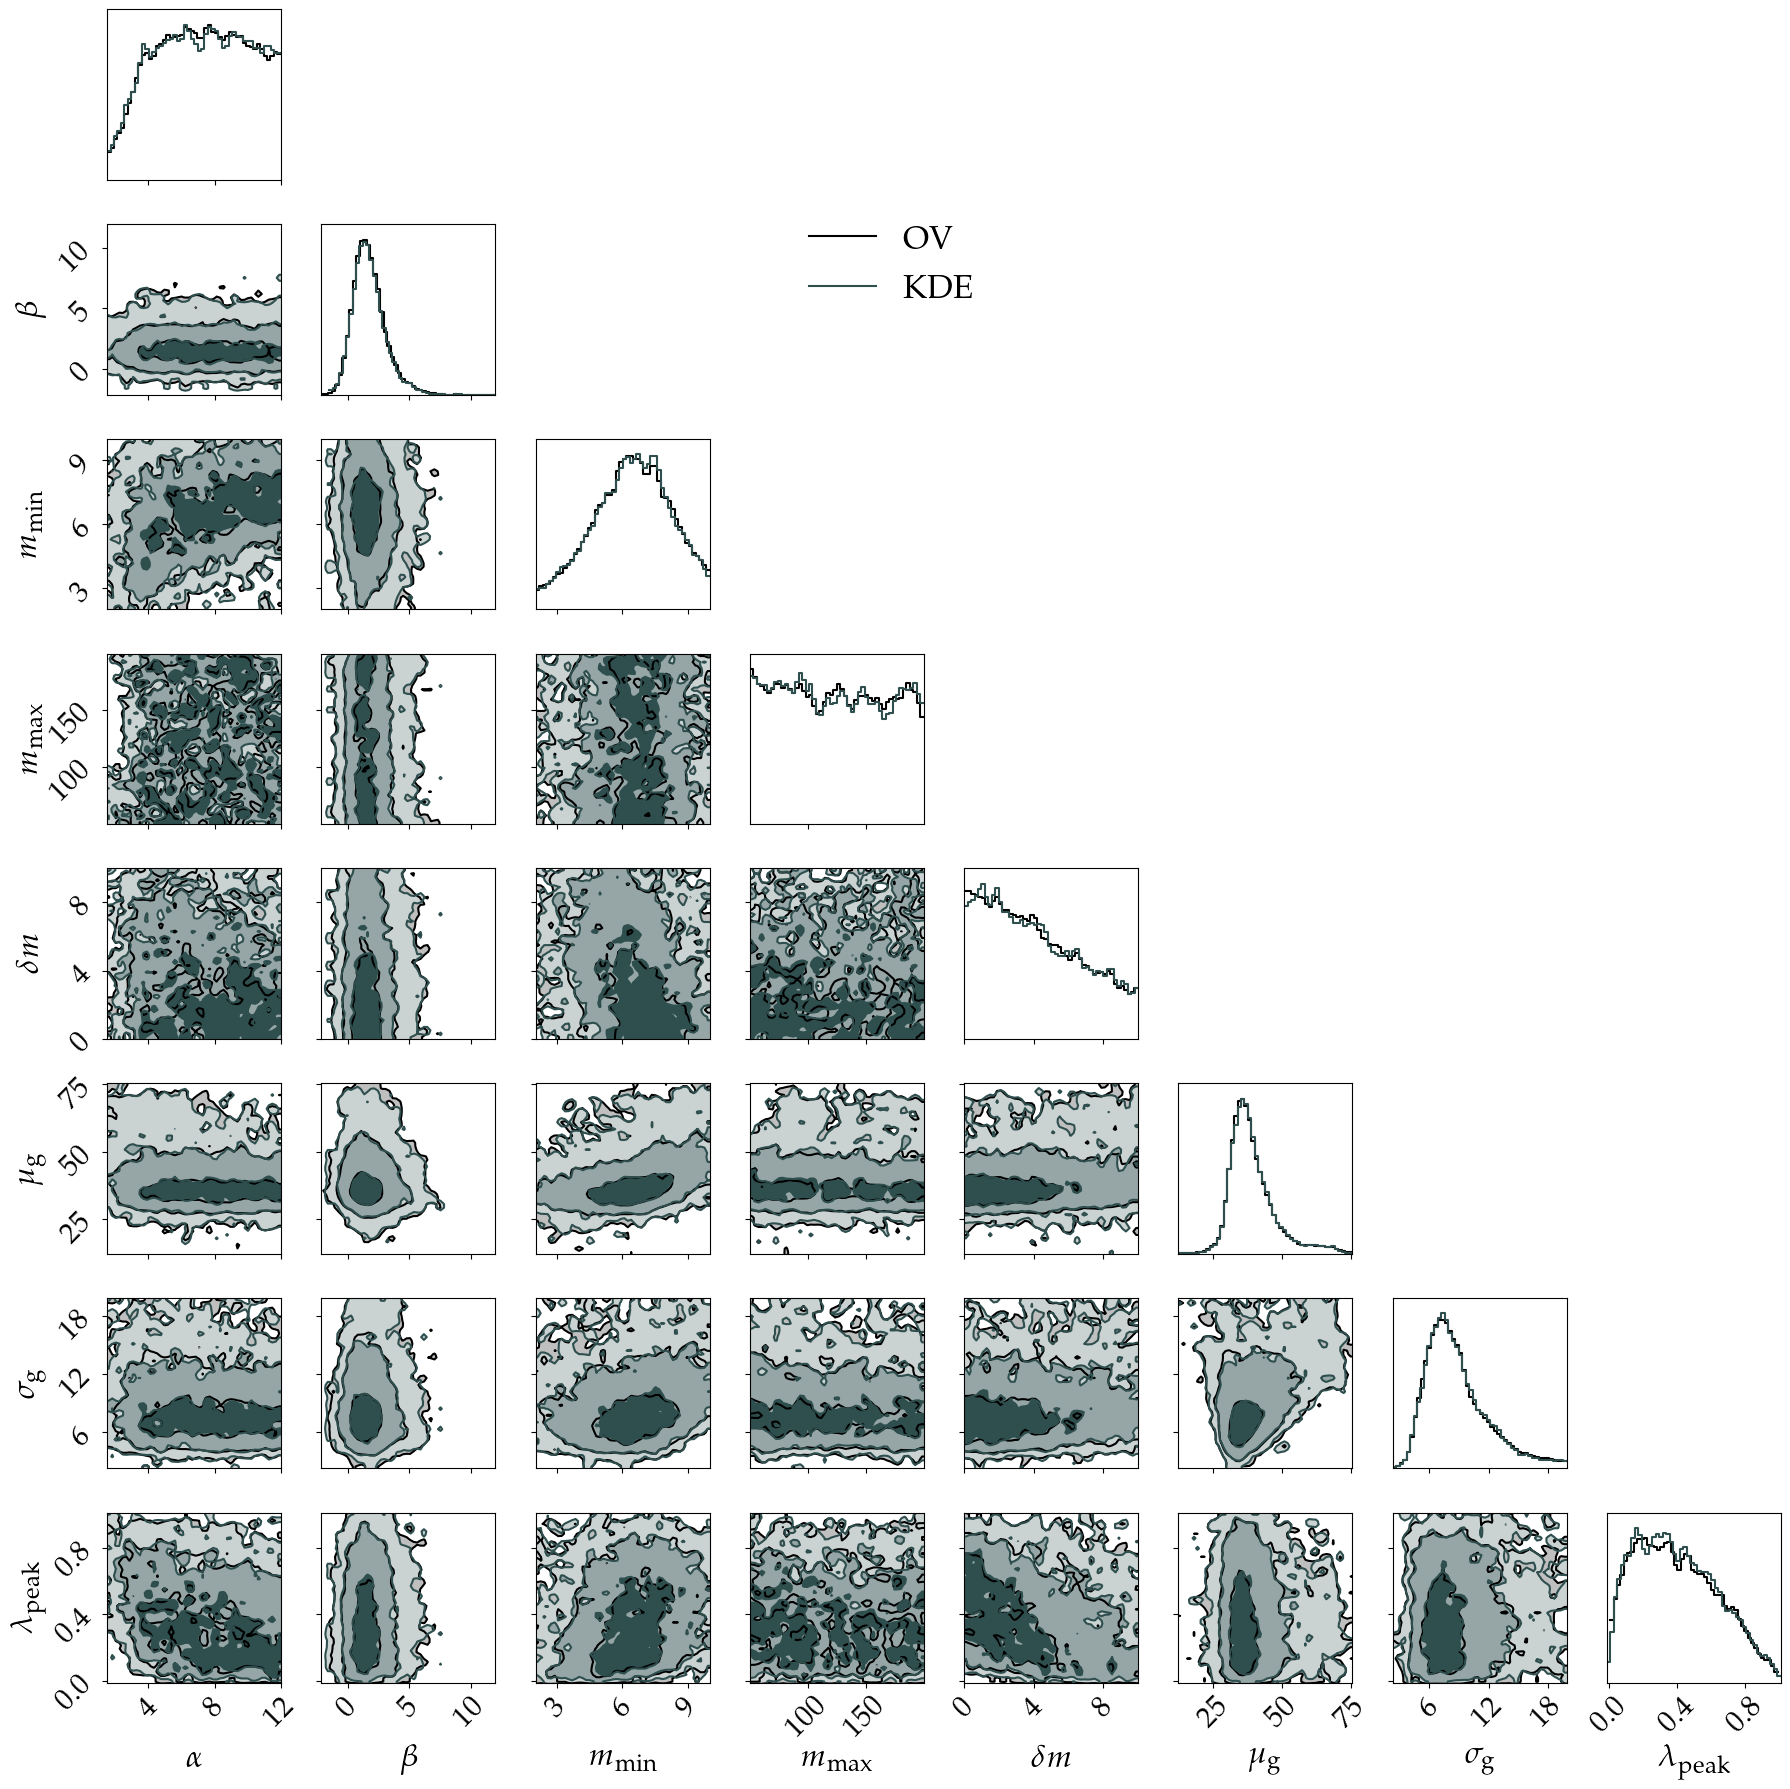

/tmp/ipykernel_1722751/4169313074.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zbin2_pe_sel['density'] = density


In [75]:
kde_bin2 = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(zbin2_pe_sel)

np.random.seed(42)
kde_df_bin2 = kde_bin2.sample(n_samples=len(zbin2_pe_sel))

# compare corner plots as well
figure = corner.corner(zbin2_pe_sel[red_mass_params], color = 'black', **default_kwargs)
corner.corner(kde_df_bin2, labels=red_mass_params_lbs, color = my_color, fig = figure, **default_kwargs)

for ax in figure.get_axes():
    ax.tick_params(axis = 'both', labelsize = 21)
    
figure.legend(['OV', 'KDE'], loc = 'center', ncol = 1, 
              bbox_to_anchor = (0.5, 0.85), fontsize = 24, frameon=False)
plt.tight_layout()
plt.show()

log_density = kde_bin2.score_samples(zbin2_pe_sel)
density = np.exp(log_density)
zbin2_pe_sel['density'] = density
df_bin2_sorted = zbin2_pe_sel.sort_values('density', ascending=False)
df_bin2_sorted['cumulative_density'] = df_bin2_sorted['density'].cumsum()
total_density = df_bin2_sorted['density'].sum()
cutoff_density = 0.68 * total_density
df_hdi_bin2 = df_bin2_sorted[df_bin2_sorted['cumulative_density'] <= cutoff_density]

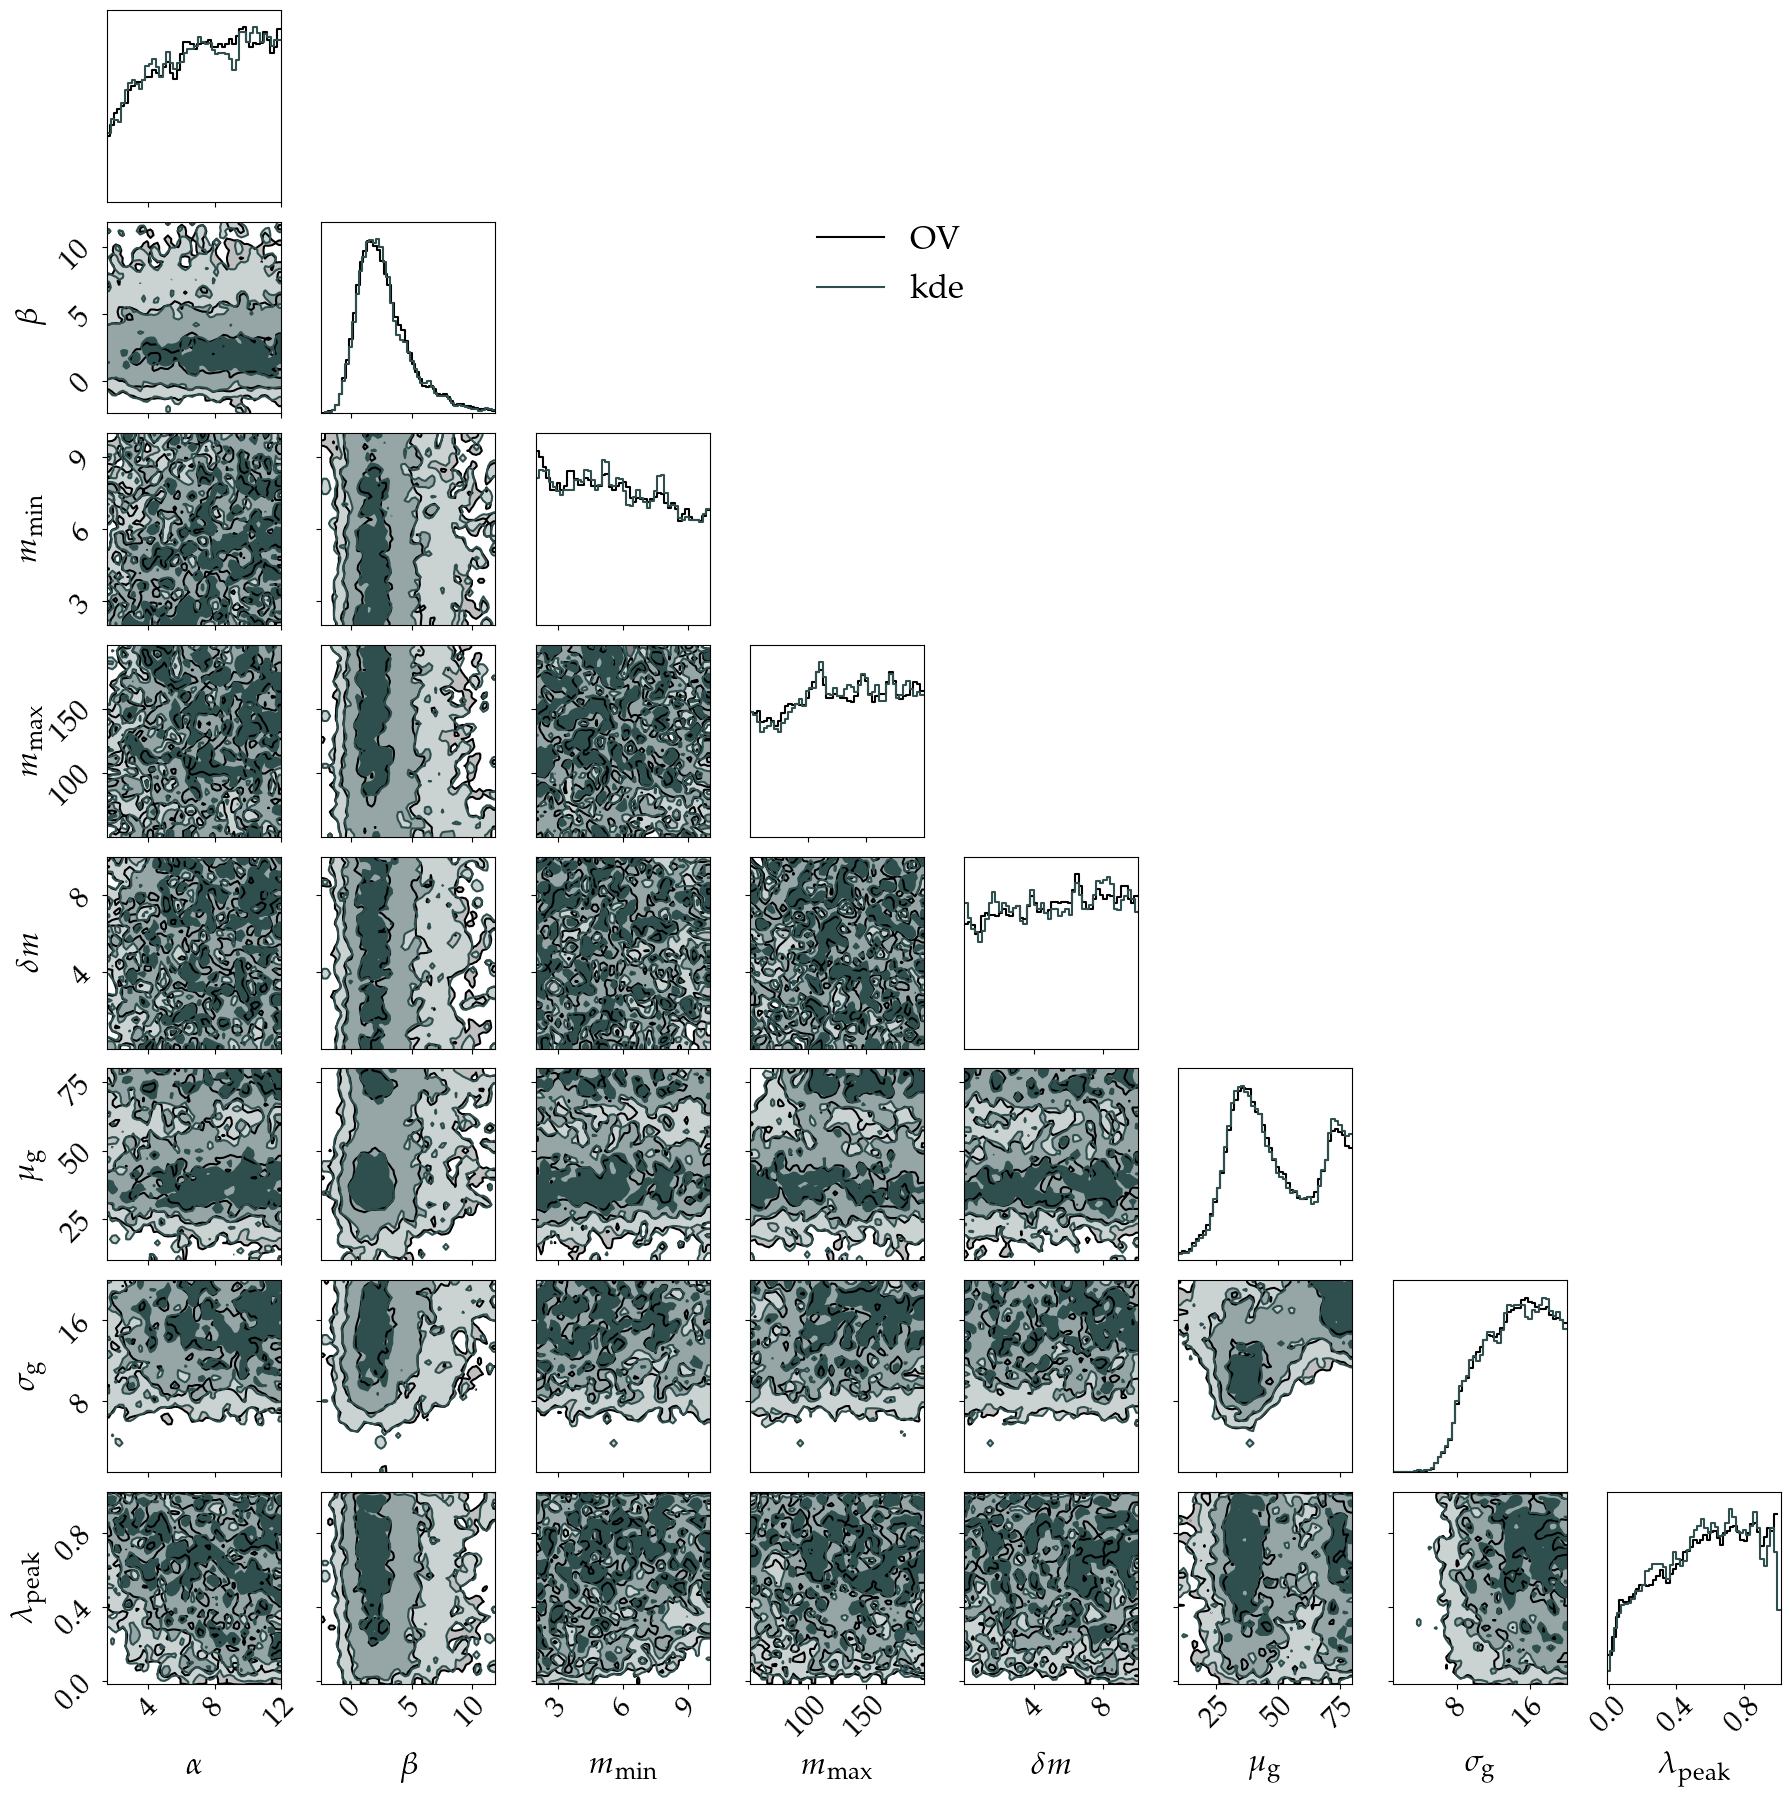

/tmp/ipykernel_1722751/4084119028.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zbin3_pe_sel['density'] = density


In [76]:
kde_bin3 = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(zbin3_pe_sel)

np.random.seed(42)
kde_df_bin3 = kde_bin3.sample(n_samples=len(zbin3_pe_sel))

# compare corner plots as well
figure = corner.corner(zbin3_pe_sel[red_mass_params], color = 'black', **default_kwargs)
corner.corner(kde_df_bin3, labels=red_mass_params_lbs, color = my_color, fig = figure, **default_kwargs)

for ax in figure.get_axes():
    ax.tick_params(axis = 'both', labelsize = 21)
    
figure.legend(['OV', 'kde'], loc = 'center', ncol = 1, 
              bbox_to_anchor = (0.5, 0.85), fontsize = 24, frameon=False)
plt.tight_layout()
plt.show()

log_density = kde_bin3.score_samples(zbin3_pe_sel)
density = np.exp(log_density)
zbin3_pe_sel['density'] = density
df_bin3_sorted = zbin3_pe_sel.sort_values('density', ascending=False)
df_bin3_sorted['cumulative_density'] = df_bin3_sorted['density'].cumsum()
total_density = df_bin3_sorted['density'].sum()
cutoff_density = 0.68 * total_density
df_hdi_bin3 = df_bin3_sorted[df_bin3_sorted['cumulative_density'] <= cutoff_density]

In [77]:
warnings.filterwarnings("ignore")

In [78]:
mm = np.linspace(8, 85, 50)
M1, M2 = np.meshgrid(mm,mm)

In [79]:
mass_wrap = icarogw.wrappers.massprior_PowerLawPeak()
mass_wrap=icarogw.wrappers.m1m2_conditioned_lowpass(mass_wrap)


n_posterior_samples_bin1 = len(df_hdi_bin1)
m1_prob_bin1, m2_prob_bin1  = np.zeros((n_posterior_samples_bin1, len(mm))), np.zeros((n_posterior_samples_bin1, len(mm)))

n_posterior_samples_bin2 = len(df_hdi_bin2)
m1_prob_bin2, m2_prob_bin2  = np.zeros((n_posterior_samples_bin2, len(mm))), np.zeros((n_posterior_samples_bin2, len(mm)))

n_posterior_samples_bin3 = len(df_hdi_bin3)
m1_prob_bin3, m2_prob_bin3 = np.zeros((n_posterior_samples_bin3, len(mm))), np.zeros((n_posterior_samples_bin3, len(mm)))

100%|██████████| 3358/3358 [03:56<00:00, 14.21it/s]


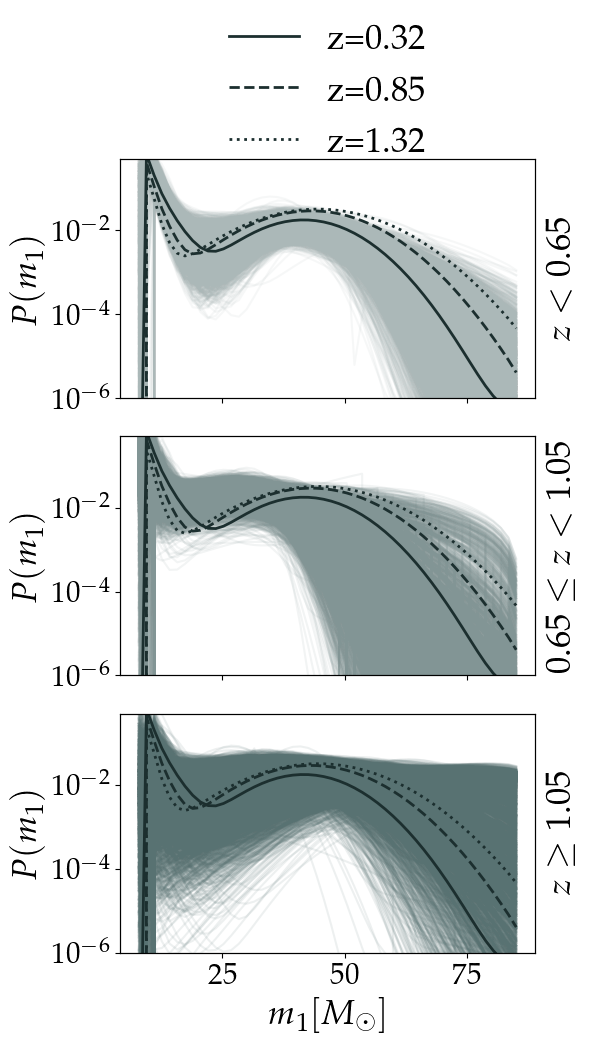

In [80]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(6, 10))

for i in tqdm(range(n_posterior_samples_bin1)):
    alpha = df_hdi_bin1['alpha'].iloc[i]
    beta = df_hdi_bin1['beta'].iloc[i]
    mmin = df_hdi_bin1['mmin'].iloc[i]
    mmax = df_hdi_bin1['mmax'].iloc[i]
    delta_m = df_hdi_bin1['delta_m'].iloc[i]
    mu_g = df_hdi_bin1['mu_g'].iloc[i]
    sigma_g = df_hdi_bin1['sigma_g'].iloc[i]
    lambda_peak = df_hdi_bin1['lambda_peak'].iloc[i]
    
    mass_wrap.update(**{'alpha':alpha,'beta':beta,'mmin':mmin,'mmax':mmax,'delta_m':delta_m,'mu_g':mu_g,'sigma_g':sigma_g,'lambda_peak':lambda_peak})
    pdf=mass_wrap.pdf(M1,M2)
    
    m1_prob_bin1[i, :] = np.trapz(pdf,mm,axis=0)
    m2_prob_bin1[i, :] = np.trapz(pdf,mm,axis=1)
    
    sns.lineplot(x = mm, y = m1_prob_bin1[i, :], color=shade0, alpha=0.1, ax = ax[0])


for i in tqdm(range(n_posterior_samples_bin2)):
    alpha = df_hdi_bin2['alpha'].iloc[i]
    beta = df_hdi_bin2['beta'].iloc[i]
    mmin = df_hdi_bin2['mmin'].iloc[i]
    mmax = df_hdi_bin2['mmax'].iloc[i]
    delta_m = df_hdi_bin2['delta_m'].iloc[i]
    mu_g = df_hdi_bin2['mu_g'].iloc[i]
    sigma_g = df_hdi_bin2['sigma_g'].iloc[i]
    lambda_peak = df_hdi_bin2['lambda_peak'].iloc[i]
    mass_wrap.update(**{'alpha':alpha,'beta':beta,'mmin':mmin,'mmax':mmax,'delta_m':delta_m,'mu_g':mu_g,'sigma_g':sigma_g,'lambda_peak':lambda_peak})
    pdf=mass_wrap.pdf(M1,M2)
    
    m1_prob_bin2[i, :] = np.trapz(pdf,mm,axis=0)
    m2_prob_bin2[i, :] = np.trapz(pdf,mm,axis=1)
    
    sns.lineplot(x = mm, y = m2_prob_bin2[i, :], color=shade1, alpha=0.1, ax = ax[1])
    
for i in tqdm(range(n_posterior_samples_bin3)):
    alpha = df_hdi_bin3['alpha'].iloc[i]
    beta = df_hdi_bin3['beta'].iloc[i]
    mmin = df_hdi_bin3['mmin'].iloc[i]
    mmax = df_hdi_bin3['mmax'].iloc[i]
    delta_m = df_hdi_bin3['delta_m'].iloc[i]
    mu_g = df_hdi_bin3['mu_g'].iloc[i]
    sigma_g = df_hdi_bin3['sigma_g'].iloc[i]
    lambda_peak = df_hdi_bin3['lambda_peak'].iloc[i]
    mass_wrap.update(**{'alpha':alpha,'beta':beta,'mmin':mmin,'mmax':mmax,'delta_m':delta_m,'mu_g':mu_g,'sigma_g':sigma_g,'lambda_peak':lambda_peak})
    pdf=mass_wrap.pdf(M1,M2)
    
    m1_prob_bin3[i, :] = np.trapz(pdf,mm,axis=0)
    m2_prob_bin3[i, :] = np.trapz(pdf,mm,axis=1)
    
    sns.lineplot(x = mm, y = m1_prob_bin3[i, :], color=shade2, alpha=0.1, ax = ax[2])
    
    
    
mirror_lbs = ['$z<0.65$', '$0.65 \le z < 1.05$', '$z\ge 1.05$']
for j in range(3):
    ax[j].set_ylim(10**(-6), 0.5)
    ax[j].set_yscale('log')
    ax[j].set_ylabel('$P(m_1)$', fontsize = 25)
    ax_mirror = ax[j].twinx()

    ax_mirror.set_ylabel('%s' %mirror_lbs[j], fontsize = 25)
    ax_mirror.set_yticks([])

    
    
    my_z = 0.32 
    mass_wrap.update(**{'alpha':alpha_z_inj(my_z),'beta':beta_z_inj(my_z),'mmin':mmin_z_inj(my_z),
                        'mmax':mmax_z_inj(my_z),'delta_m':delta_m_z(),'mu_g':mu_g_z_inj(my_z),
                        'sigma_g':sigma_g_z_inj(my_z),'lambda_peak':lambda_peak_z_inj(my_z)})
    pdf=mass_wrap.pdf(M1,M2)
    mass_prob = np.trapz(pdf,mm,axis=0)
    sns.lineplot(x = mm, y = mass_prob, color=shade3, linestyle='solid', label='z=%s' %my_z,
                linewidth=2, ax = ax[j])
    
    my_z = 0.85 
    mass_wrap.update(**{'alpha':alpha_z_inj(my_z),'beta':beta_z_inj(my_z),'mmin':mmin_z_inj(my_z),
                        'mmax':mmax_z_inj(my_z),'delta_m':delta_m_z(),'mu_g':mu_g_z_inj(my_z),
                        'sigma_g':sigma_g_z_inj(my_z),'lambda_peak':lambda_peak_z_inj(my_z)})
    pdf=mass_wrap.pdf(M1,M2)
    mass_prob = np.trapz(pdf,mm,axis=0)
    sns.lineplot(x = mm, y = mass_prob,
                color=shade3, linestyle='dashed', label='z=%s' %my_z,
                linewidth=2, ax = ax[j])
    my_z = 1.32 
    mass_wrap.update(**{'alpha':alpha_z_inj(my_z),'beta':beta_z_inj(my_z),'mmin':mmin_z_inj(my_z),
                        'mmax':mmax_z_inj(my_z),'delta_m':delta_m_z(),'mu_g':mu_g_z_inj(my_z),
                        'sigma_g':sigma_g_z_inj(my_z),'lambda_peak':lambda_peak_z_inj(my_z)})
    pdf=mass_wrap.pdf(M1,M2)
    mass_prob = np.trapz(pdf,mm,axis=0)
    sns.lineplot(x = mm, y = mass_prob,
                color=shade3, linestyle='dotted', label='z=%s' %my_z,
                linewidth=2, ax = ax[j])
    
    
ax[2].set_xlabel('$m_1 [M_{\odot}]$', fontsize = 25)

ax[0].legend(loc = 'center', ncol = 1, 
            bbox_to_anchor = (0.5, 1.28), fontsize = 25, frameon=False)
ax[1].legend_.remove()
ax[2].legend_.remove()

plt.subplots_adjust(top=0.25, 
                    wspace=-0.75, 
                    hspace=0.)

plt.tight_layout()
plt.savefig(path_to_plots + '/' + 'redshift_mass_samples_hdi_icaro.pdf', bbox_inches='tight')
plt.show()

## Vanilla case

In [81]:
# load dictionary of events
case1_dictionary_path = '/home/ulyana.dupletsa/MDC-Paper1/data/case1_events_dictionary.pkl'
with open(case1_dictionary_path, 'rb') as f:
    case1_dict = pickle.load(f)

In [82]:
case1_test_data = bilby.core.result.read_in_result(case1_dict['case1_inj_number']['case1_1e6inj_286ev'])
case1_test_data_posteriors = case1_test_data.posterior[columns_lbs]

### Rate plots

In [83]:
R0_vanilla = injected_values_vanilla['R0']
gamma_vanilla = injected_values_vanilla['gamma']
kappa_vanilla = injected_values_vanilla['kappa']
zp_vanilla = injected_values_vanilla['zp']

In [84]:
rate_posteriors_vanilla = case1_test_data_posteriors[['R0', 'gamma', 'zp', 'kappa']]

In [85]:
n_posterior_samples_vanilla = len(rate_posteriors_vanilla)

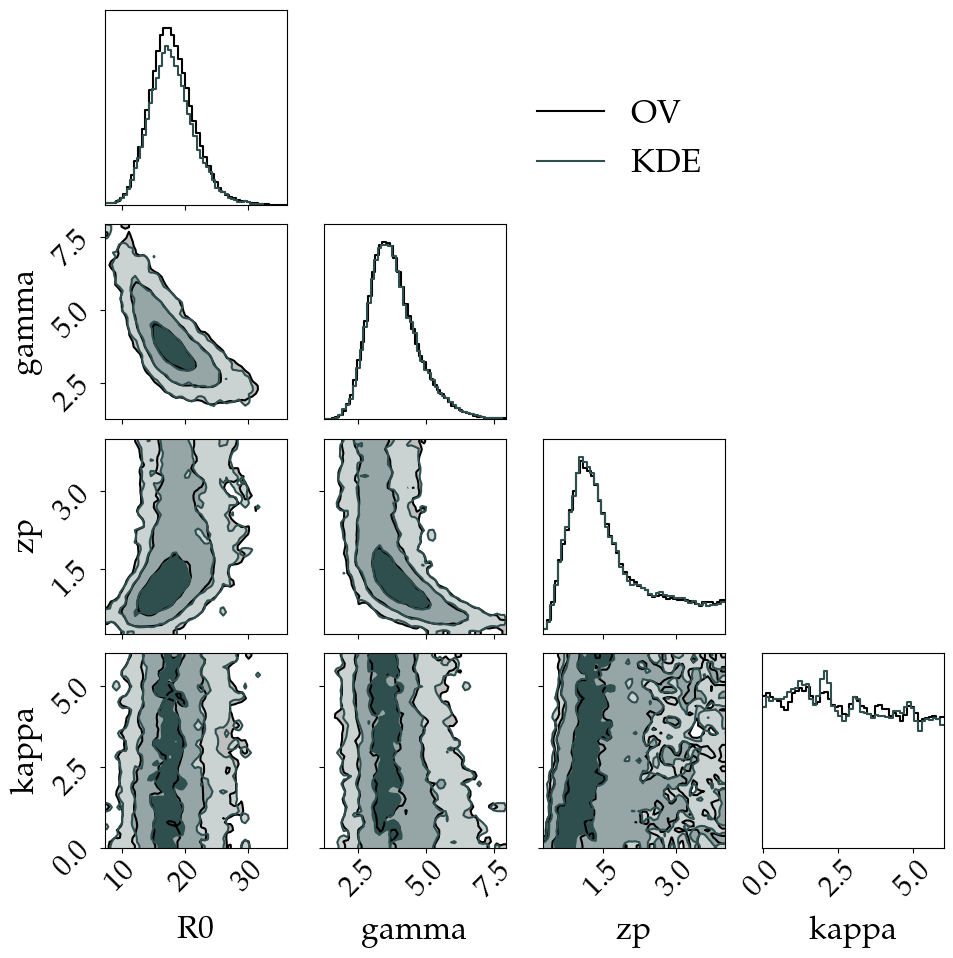

In [86]:
kde_van = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(rate_posteriors_vanilla)

np.random.seed(42)
kde_df_van = kde_van.sample(n_samples=len(rate_posteriors_vanilla))

# compare corner plots as well
figure = corner.corner(rate_posteriors_vanilla[rate_params], color = 'black', **default_kwargs)
corner.corner(kde_df_van, labels=rate_params, color = my_color, fig = figure, **default_kwargs)

for ax in figure.get_axes():
    ax.tick_params(axis = 'both', labelsize = 21)
    
figure.legend(['OV', 'KDE'], loc = 'center', ncol = 1, 
              bbox_to_anchor = (0.65, 0.85), fontsize = 24, frameon=False)
plt.tight_layout()
plt.show()

log_density = kde_van.score_samples(rate_posteriors_vanilla)
density = np.exp(log_density)
rate_posteriors_vanilla['density'] = density
df_van_sorted = rate_posteriors_vanilla.sort_values('density', ascending=False)
df_van_sorted['cumulative_density'] = df_van_sorted['density'].cumsum()
total_density = rate_posteriors_vanilla['density'].sum()
cutoff_density = 0.68 * total_density
df_hdi_van = df_van_sorted[df_van_sorted['cumulative_density'] <= cutoff_density]

100%|██████████| 5892/5892 [04:41<00:00, 20.96it/s]


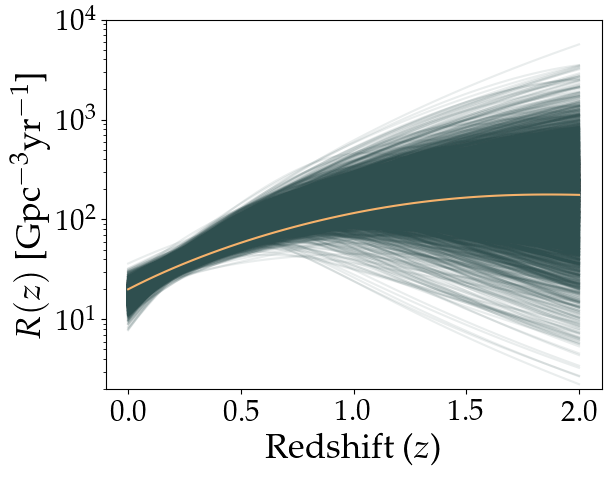

In [87]:
fig, ax = plt.subplots()
for i in tqdm(range(len(df_hdi_van))):
    R0_sample = df_hdi_van['R0'].iloc[i]
    gamma_sample = df_hdi_van['gamma'].iloc[i]
    zp_sample = df_hdi_van['zp'].iloc[i]
    kappa_sample = df_hdi_van['kappa'].iloc[i]
    sns.lineplot(x = zz, y = z_dependent_rate(zz, R0_sample, gamma_sample, zp_sample, kappa_sample),
             color=my_color, alpha=0.1)
    
sns.lineplot(x = zz, y = z_dependent_rate(zz, R0_vanilla, gamma_vanilla, zp_vanilla, kappa_vanilla),
         color=my_color2, linewidth=1.5)

plt.xlabel('Redshift ($z$)', fontsize = 25)
plt.ylabel('$R(z)$ [Gpc$^{-3}$yr$^{-1}$]', fontsize = 25) 
plt.yscale('log')
plt.ylim(2, 10**4)
plt.savefig(path_to_plots + '/' + 'vanilla_rate_samples_hdi.pdf', bbox_inches='tight')
plt.show()

### Mass plots

In [88]:
mm = np.linspace(5, 99, 50)

In [89]:
mass_params = ['alpha', 'beta', 'mmin', 'mmax', 'delta_m', 'mu_g', 'sigma_g', 'lambda_peak']

In [90]:
mass_model_vanilla_data = case1_test_data_posteriors[mass_params]

In [91]:
alpha_v_inj = injected_values_vanilla['alpha']
beta_v_inj = injected_values_vanilla['beta']
mmin_v_inj = injected_values_vanilla['mmin']
mmax_v_inj = injected_values_vanilla['mmax']
delta_m_v_inj = injected_values_vanilla['delta_m']
mu_g_v_inj = injected_values_vanilla['mu_g']
sigma_g_v_inj = injected_values_vanilla['sigma_g']
lambda_peak_v_inj = injected_values_vanilla['lambda_peak']

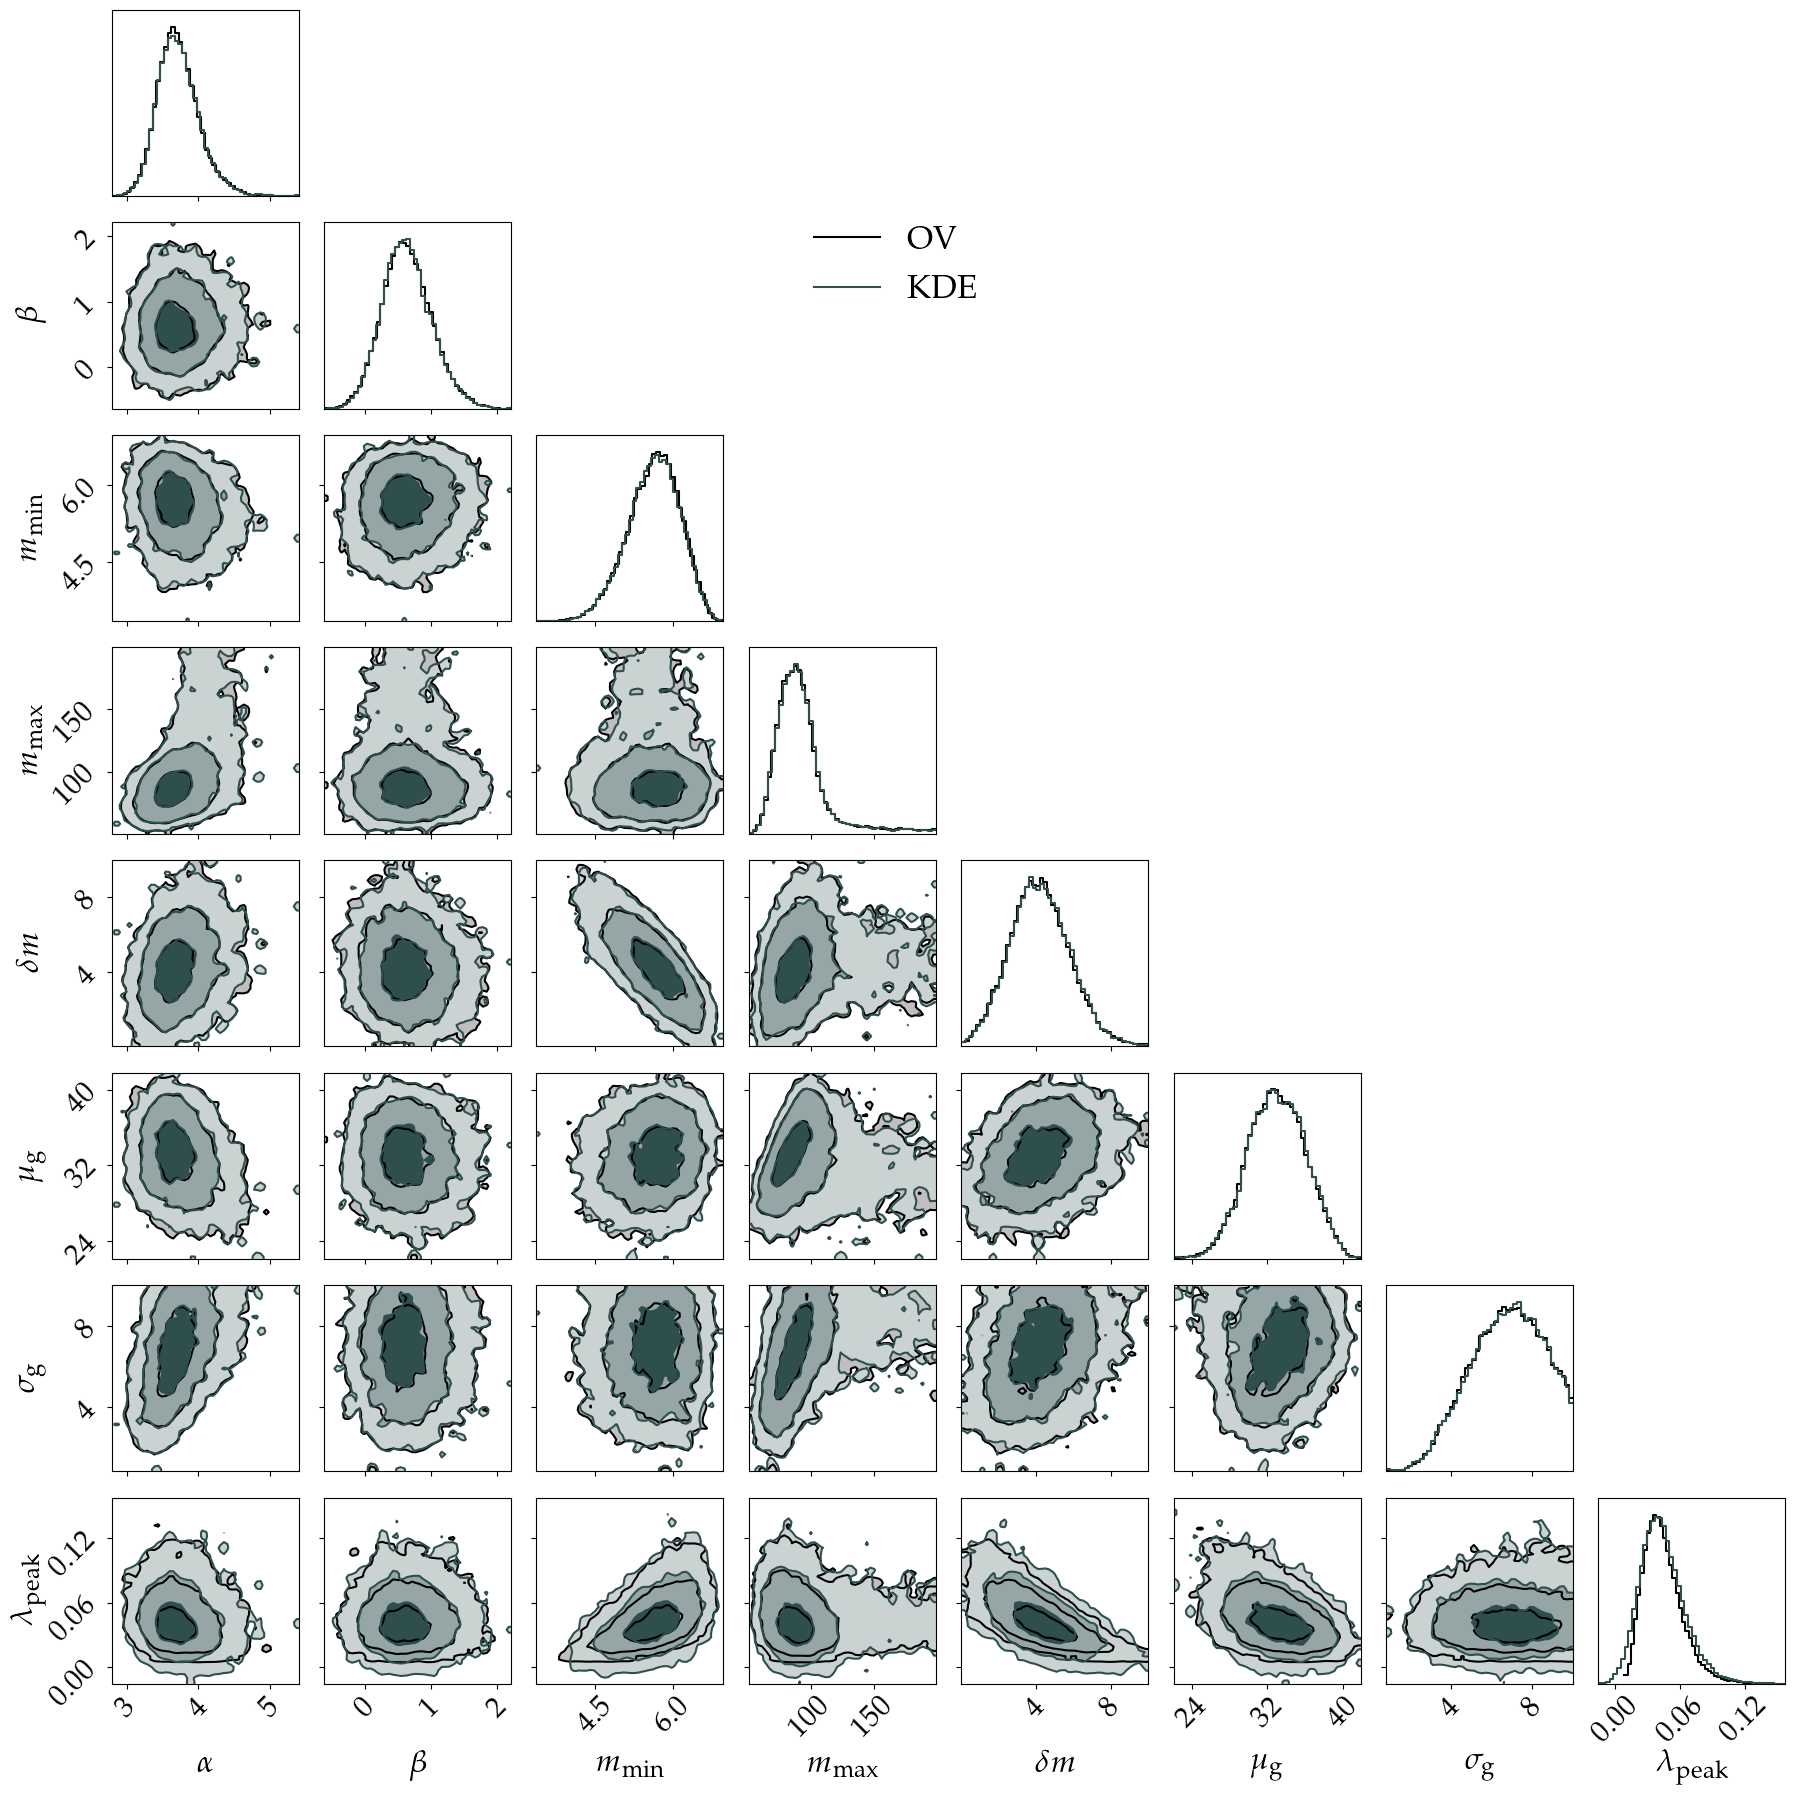

In [92]:
kde_mass_van = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(mass_model_vanilla_data)

np.random.seed(11)
kde_df_mass_van = kde_mass_van.sample(n_samples=len(mass_model_vanilla_data))

# compare corner plots as well
figure = corner.corner(mass_model_vanilla_data[mass_params], color = 'black', **default_kwargs)
corner.corner(kde_df_mass_van, labels=red_mass_params_lbs, color = my_color, fig = figure, **default_kwargs)

for ax in figure.get_axes():
    ax.tick_params(axis = 'both', labelsize = 21)
    
figure.legend(['OV', 'KDE'], loc = 'center', ncol = 1, 
              bbox_to_anchor = (0.5, 0.85), fontsize = 24, frameon=False)
plt.tight_layout()
plt.show()

log_density = kde_mass_van.score_samples(mass_model_vanilla_data)
density = np.exp(log_density)
mass_model_vanilla_data['density'] = density
df_mass_van_sorted = mass_model_vanilla_data.sort_values('density', ascending=False)
df_mass_van_sorted['cumulative_density'] = df_mass_van_sorted['density'].cumsum()
total_density = mass_model_vanilla_data['density'].sum()
cutoff_density = 0.68 * total_density
df_hdi_mass_van = df_mass_van_sorted[df_mass_van_sorted['cumulative_density'] <= cutoff_density]

In [93]:
mm = np.linspace(5, 99, 50)
M1, M2 = np.meshgrid(mm,mm)

In [94]:
mass_wrap = icarogw.wrappers.massprior_PowerLawPeak()
mass_wrap=icarogw.wrappers.m1m2_conditioned_lowpass(mass_wrap)


n_posterior_samples = len(df_hdi_mass_van)
m1_prob, m2_prob  = np.zeros((n_posterior_samples, len(mm))), np.zeros((n_posterior_samples, len(mm)))

100%|██████████| 5892/5892 [05:12<00:00, 18.87it/s]


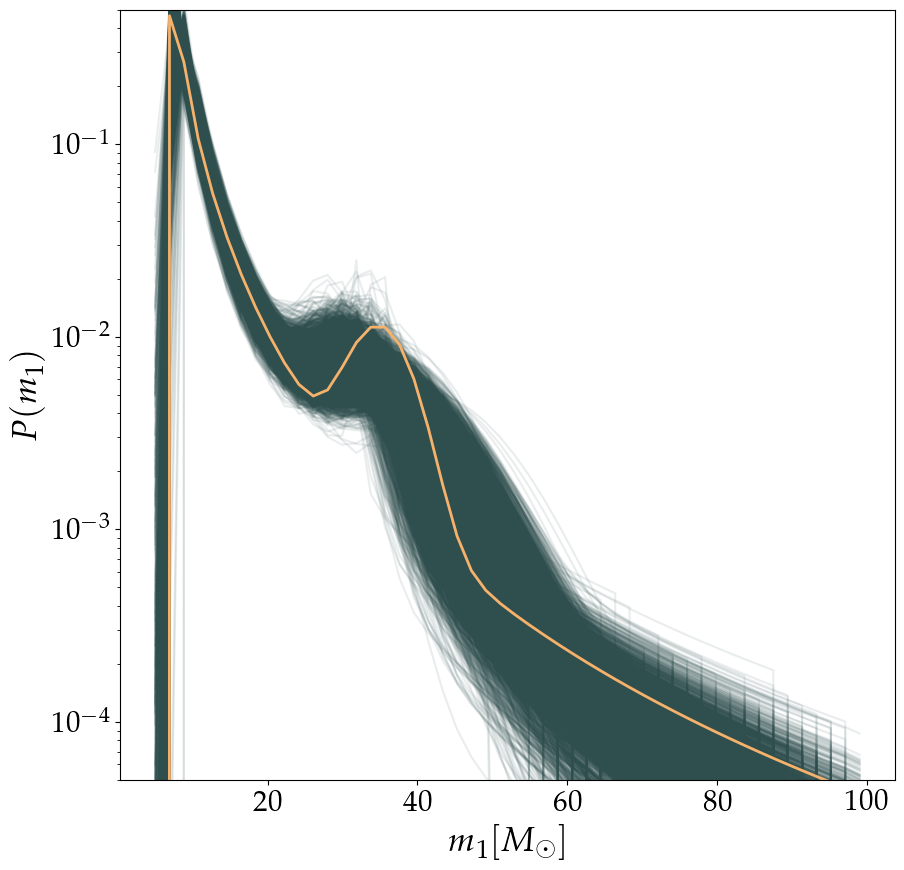

In [95]:
fig, ax = plt.subplots(figsize=(10,10))

for i in tqdm(range(n_posterior_samples)):
    alpha = df_hdi_mass_van['alpha'].iloc[i]
    beta = df_hdi_mass_van['beta'].iloc[i]
    mmin = df_hdi_mass_van['mmin'].iloc[i]
    mmax = df_hdi_mass_van['mmax'].iloc[i]
    delta_m = df_hdi_mass_van['delta_m'].iloc[i]
    mu_g = df_hdi_mass_van['mu_g'].iloc[i]
    sigma_g = df_hdi_mass_van['sigma_g'].iloc[i]
    lambda_peak = df_hdi_mass_van['lambda_peak'].iloc[i]
    
    mass_wrap.update(**{'alpha':alpha,'beta':beta,'mmin':mmin,'mmax':mmax,'delta_m':delta_m,'mu_g':mu_g,'sigma_g':sigma_g,'lambda_peak':lambda_peak})
    pdf=mass_wrap.pdf(M1,M2)
    
    m1_prob[i, :] = np.trapz(pdf,mm,axis=0)
    m2_prob[i, :] = np.trapz(pdf,mm,axis=1)
    
    sns.lineplot(x = mm, y = m1_prob[i, :], color=my_color, alpha=0.1)

    
mass_wrap.update(**{'alpha':alpha_v_inj,'beta':beta_v_inj,'mmin':mmin_v_inj,'mmax':mmax_v_inj,
                    'delta_m':delta_m_v_inj,'mu_g':mu_g_v_inj,'sigma_g':sigma_g_v_inj,
                    'lambda_peak':lambda_peak_v_inj})
pdf=mass_wrap.pdf(M1,M2)   
m1_prob = np.trapz(pdf,mm,axis=0)
sns.lineplot(x = mm, y = m1_prob,
            color=my_color2, linestyle='solid',
            linewidth=2)

plt.xlabel('$m_1 [M_{\odot}]$', fontsize = 25)
plt.ylabel('$P(m_1)$', fontsize = 25)
plt.yscale('log')
plt.ylim(5*10**(-5), 0.5)
plt.savefig(path_to_plots + '/' + 'vanilla_mass_samples_hdi_icaro.pdf', bbox_inches='tight')
plt.show()